## Analysis of mutation prediction results

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
results_dir = os.path.join(
    'results', 'univariate_fs', 'pancancer'
)

In [3]:
results_df = (
    au.load_prediction_results_fs(results_dir, cfg.fs_methods)
)

# temporary, change later
results_df = results_df[results_df.gene == 'TP53'].copy()

results_df.loc[
    (results_df.fs_method == 'mad') & (results_df.n_dims == 100),
    'fs_method'
] = 'mad_100'
results_df.loc[
    (results_df.fs_method == 'mad') & (results_df.n_dims == 1000),
    'fs_method'
] = 'mad_1000'

print(results_df.shape)
print(results_df.fs_method.unique())
print(results_df.n_dims.unique())
results_df.head()

(240, 10)
['median_f_test' 'mad_100' 'mad_1000' 'mad_f_test' 'pancan_f_test']
[ 100 1000]


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,fs_method,n_dims
0,0.55681,0.53291,TP53,NaN,shuffled,42,train,0,median_f_test,100
1,0.49419,0.46362,TP53,NaN,shuffled,42,test,0,median_f_test,100
2,0.51169,0.48608,TP53,NaN,shuffled,42,cv,0,median_f_test,100
3,0.54038,0.50844,TP53,NaN,shuffled,42,train,1,median_f_test,100
4,0.52547,0.49144,TP53,NaN,shuffled,42,test,1,median_f_test,100


In [4]:
compare_df = []
for fs_method in results_df.fs_method.unique():
    print(fs_method, file=sys.stderr)
    compare_df.append(
        au.compare_control_ind(results_df[results_df.fs_method == fs_method],
                               metric='aupr', verbose=True)
          .assign(fs_method=fs_method)
    )
compare_df = pd.concat(compare_df)

print(compare_df.shape)
compare_df.head()

(40, 5)


median_f_test
mad_100
mad_1000
mad_f_test
pancan_f_test


,identifier,seed,fold,delta_aupr,fs_method
0,TP53,42,0,0.38053,median_f_test
1,TP53,42,1,0.36588,median_f_test
2,TP53,42,2,0.40707,median_f_test
3,TP53,42,3,0.38879,median_f_test
4,TP53,1,0,0.37406,median_f_test


(0.0, 1.0)

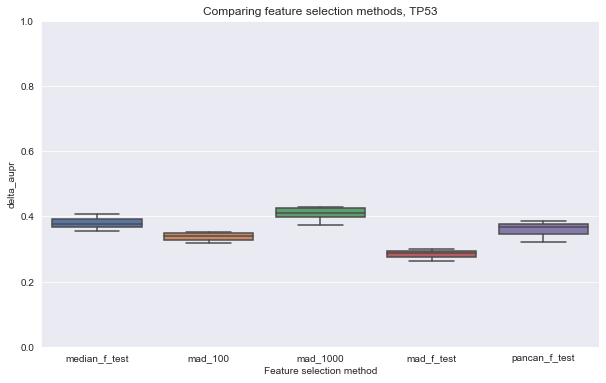

In [5]:
sns.set({'figure.figsize': (10, 6)})

sns.boxplot(data=compare_df, x='fs_method', y='delta_aupr')
plt.title('Comparing feature selection methods, {}'.format('TP53'))
plt.xlabel('Feature selection method')
plt.ylim(0, 1)